----------------------------------------------
Read Red Band
----------------------------------------------

In [ ]:
!pip install rasterio

In [ ]:
import rasterio
from rasterio.merge import merge
import numpy as np

In [ ]:
import geopandas as gpd

shapefile = '/content/drive/MyDrive/Colab Notebooks/Tomato_Broomraoe_MS_Data_2023/Data/SHP/SHP_2024-07-24_Tomato_Broomrape.shp'

# Read the shapefile
gdf = gpd.read_file(shapefile)

# Print column names
print(gdf.columns)

Index(['Id', 'Status', 'EXT_MIN_X', 'EXT_MIN_Y', 'EXT_MAX_X', 'EXT_MAX_Y',
       'geometry'],
      dtype='object')


----------------------------------------------
Red Band Clipping
----------------------------------------------

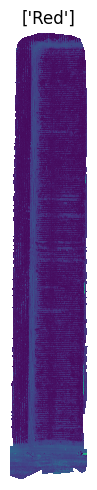

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio

# Function to normalize and mask NoData values
def normalize_and_mask(image, nodata_value):
    # Mask out NoData values
    masked_image = np.ma.masked_where(image == nodata_value, image)

    # Normalize the image to 0-1 scale
    normalized_image = np.clip(masked_image, 0, 1)
    return normalized_image

# File paths for red and NIR bands
red_file = '/content/drive/MyDrive/Colab Notebooks/Tomato_Broomraoe_MS_Data_2023/Data/2023-07-24/2023-07-24_Tomato_Broomrape_MS_transparent_reflectance_red.tif'

# Read the red and NIR images and apply normalization and masking
with rasterio.open(red_file) as src:
    red = normalize_and_mask(src.read(1), src.nodata)

# Plot settings
plt.figure(figsize=(10, 5))
titles = ['Red']

# Plot red and NIR bands
for i, image in enumerate([red]):
    plt.subplot(1, 2, i + 1)
    plt.imshow(image, cmap='viridis', vmin=0, vmax=1)
    plt.title(titles)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
import geopandas as gpd
import rasterio
from rasterio.mask import mask

# File paths
red_file = '/content/drive/MyDrive/Colab Notebooks/Tomato_Broomraoe_MS_Data_2023/Data/2023-07-24/2023-07-24_Tomato_Broomrape_MS_transparent_reflectance_red.tif'
shapefile = '/content/drive/MyDrive/Colab Notebooks/Tomato_Broomraoe_MS_Data_2023/Data/SHP/SHP_2024-07-24_Tomato_Broomrape.shp'
healthy_folder = '/content/drive/MyDrive/Colab Notebooks/Tomato_Broomraoe_MS_Data_2023/Code/2023-07-24_Output/RED_Clipped/Healthy'
broomrape_folder = '/content/drive/MyDrive/Colab Notebooks/Tomato_Broomraoe_MS_Data_2023/Code/2023-07-24_Output/RED_Clipped/Broomrape'

# Create output directories if they don't exist
os.makedirs(healthy_folder, exist_ok=True)
os.makedirs(broomrape_folder, exist_ok=True)

# Read the shapefile
gdf = gpd.read_file(shapefile)

# Read the red TIFF file
with rasterio.open(red_file) as src:
    for index, row in gdf.iterrows():
        # Create a rectangle (polygon) from the shapefile coordinates
        minx, miny, maxx, maxy = row['EXT_MIN_X'], row['EXT_MIN_Y'], row['EXT_MAX_X'], row['EXT_MAX_Y']
        geom = [{'type': 'Polygon', 'coordinates': [[(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny)]]}]

        # Clip the red TIFF file
        out_image, out_transform = mask(src, geom, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})

        # Define output path based on Status
        output_path = os.path.join(healthy_folder if row['Status'] == 0 else broomrape_folder,
                                   f"2023-07-24_ID_{row['Id']}_Band_Red.tif")

        # Save the clipped image
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

In [ ]:
import os

# Path to the folder
folder_path = '/content/drive/MyDrive/Colab Notebooks/Tomato_Broomraoe_MS_Data_2023/Code/2023-07-24_Output/RED_Clipped/Healthy'

# List all files in the folder
files = os.listdir(folder_path)

# Count the number of files (optionally, you can filter by file extension)
num_files = len(files)

print(f'There are {num_files} files in the Healthy folder.')

There are 250 files in the Healthy folder.


In [ ]:
import os

# Path to the folder
folder_path = '/content/drive/MyDrive/Colab Notebooks/Tomato_Broomraoe_MS_Data_2023/Code/2023-07-24_Output/RED_Clipped/Broomrape'

# List all files in the folder
files = os.listdir(folder_path)

# Count the number of files (optionally, you can filter by file extension)
num_files = len(files)

print(f'There are {num_files} files in the Broomrape folder.')

There are 50 files in the Broomrape folder.


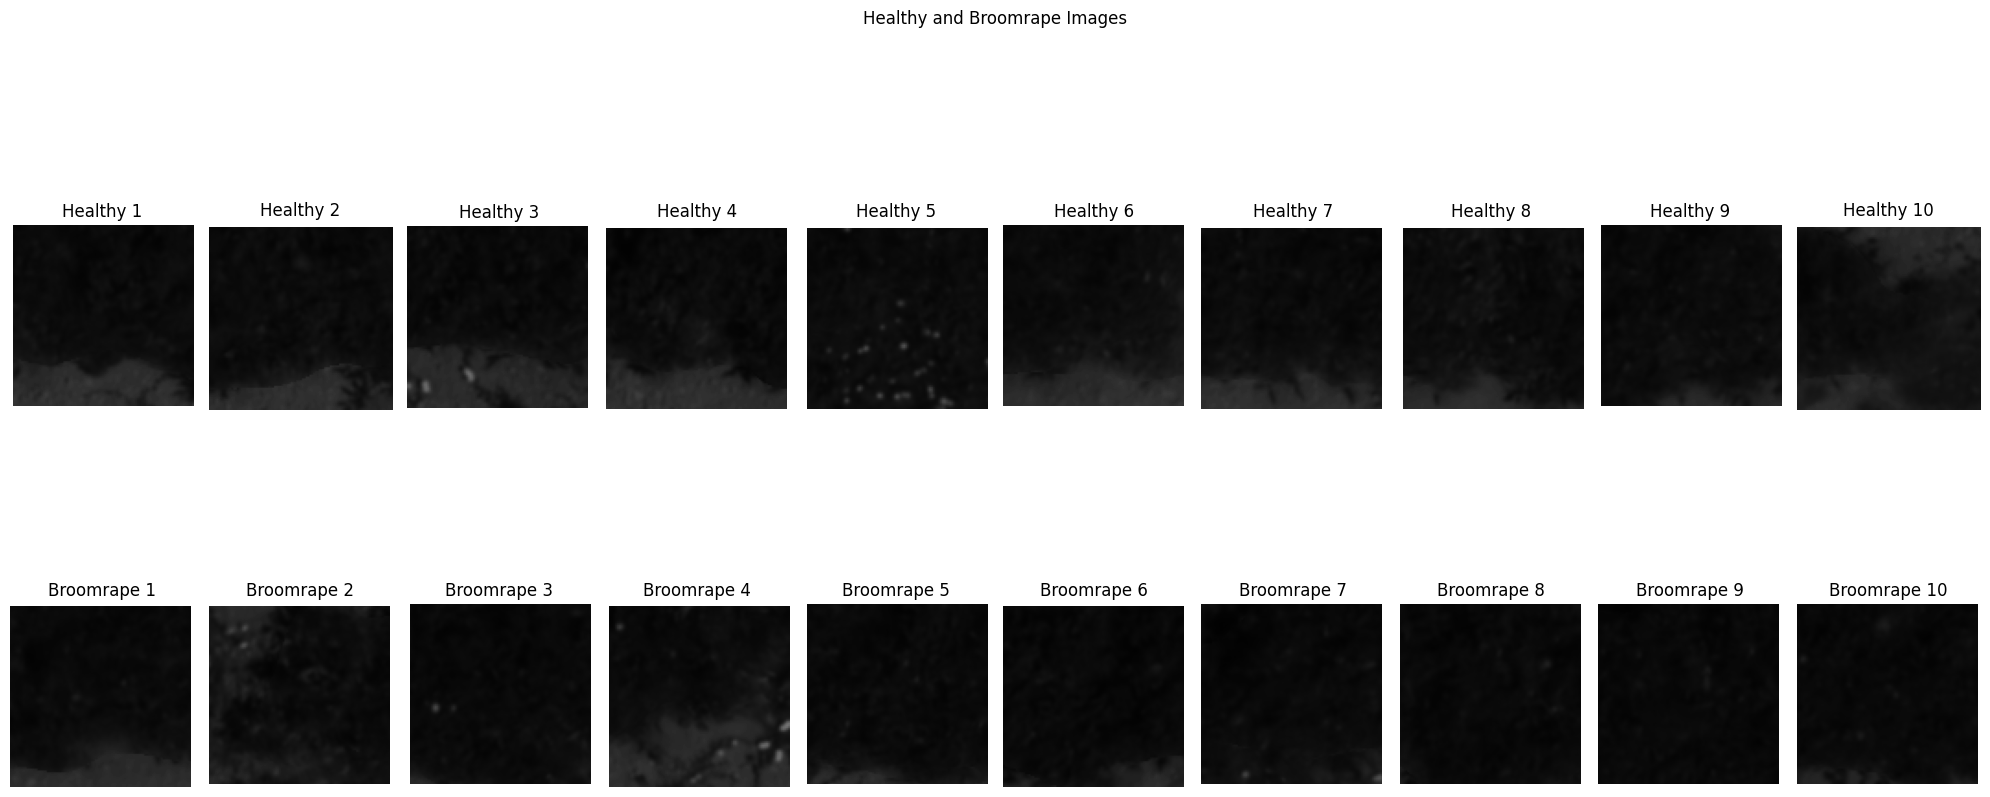

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio

# Function to normalize and mask NoData values
def normalize_and_mask(image, nodata_value):
    masked_image = np.ma.masked_where(image == nodata_value, image)
    normalized_image = np.clip(masked_image, 0, 1)
    return normalized_image

# Paths to the folders
healthy_folder = '/content/drive/MyDrive/Colab Notebooks/Tomato_Broomraoe_MS_Data_2023/Code/2023-07-24_Output/RED_Clipped/Healthy'
broomrape_folder = '/content/drive/MyDrive/Colab Notebooks/Tomato_Broomraoe_MS_Data_2023/Code/2023-07-24_Output/RED_Clipped/Broomrape'

# Get a list of files in each folder (limit to 10 each)
healthy_files = [os.path.join(healthy_folder, file) for file in os.listdir(healthy_folder)[:10]]
broomrape_files = [os.path.join(broomrape_folder, file) for file in os.listdir(broomrape_folder)[:10]]

# Plot settings
plt.figure(figsize=(20, 10))
plt.suptitle('Healthy and Broomrape Images')

# Function to plot images
def plot_images(files, start_index, title):
    for i, file in enumerate(files, start=start_index):
        with rasterio.open(file) as src:
            image = normalize_and_mask(src.read(1), src.nodata)
            plt.subplot(2, 10, i)
            plt.imshow(image, cmap='gray', vmin=0, vmax=1)
            plt.title(f'{title} {i-start_index+1}')
            plt.axis('off')

# Plot healthy images
plot_images(healthy_files, 1, 'Healthy')

# Plot broomrape images
plot_images(broomrape_files, 11, 'Broomrape')

plt.tight_layout()
plt.show()